In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import arabic_reshaper
from bidi.algorithm import get_display

from keras import layers
from keras import models
import kerastuner as kt
import keras
from IPython import display
# import librosa
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-24 14:30:00.329460: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 14:30:00.733337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 14:30:00.733381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 14:30:00.826134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 14:30:00.950783: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="quran/balanced",
    batch_size=128,
    output_sequence_length=16000,
    validation_split=0.2,
    seed=0,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6500 files belonging to 13 classes.
Using 5200 files for training.
Using 1300 files for validation.


2024-02-24 14:30:12.915395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-24 14:30:13.103158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-24 14:30:13.103204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-24 14:30:13.106633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-24 14:30:13.106670: I external/local_xla/xla/stream_executor


label names: ['ابراهيم عبد المنعم صوتيات' 'احمد الشلبي صوتيات جاهزة'
 'اسماعيل القاضي صوتيات جاهزة' 'اوريانتو' 'ايوب مصعب صوتيات جاهزة'
 'حسين عبد الضاهر صوتيات جاهزة' 'خالد طوالبة صوتيات جاهزة'
 'زين ابو الكوثر صوتيات جاهزة' 'طارق محمد صوتيات جاهزة'
 'علاء عقل صوتيات جاهز' 'علاء ياسر صوتيات جاهزة' 'محمد حجازي صوتيات جاهز'
 'مختار الحاج صوتيات جاهزة']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [3]:
def stereo_to_mono_converter(example,labels):
    audio = example
    # If it has multiple channels, take the mean to convert to mono
    audio = tf.reduce_mean(audio, axis=-1, keepdims=True)
    # Add any additional preprocessing steps here
    return audio,labels


In [4]:
train_ds = train_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)
val_ds = val_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)

In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(128, 16000)
(128,)


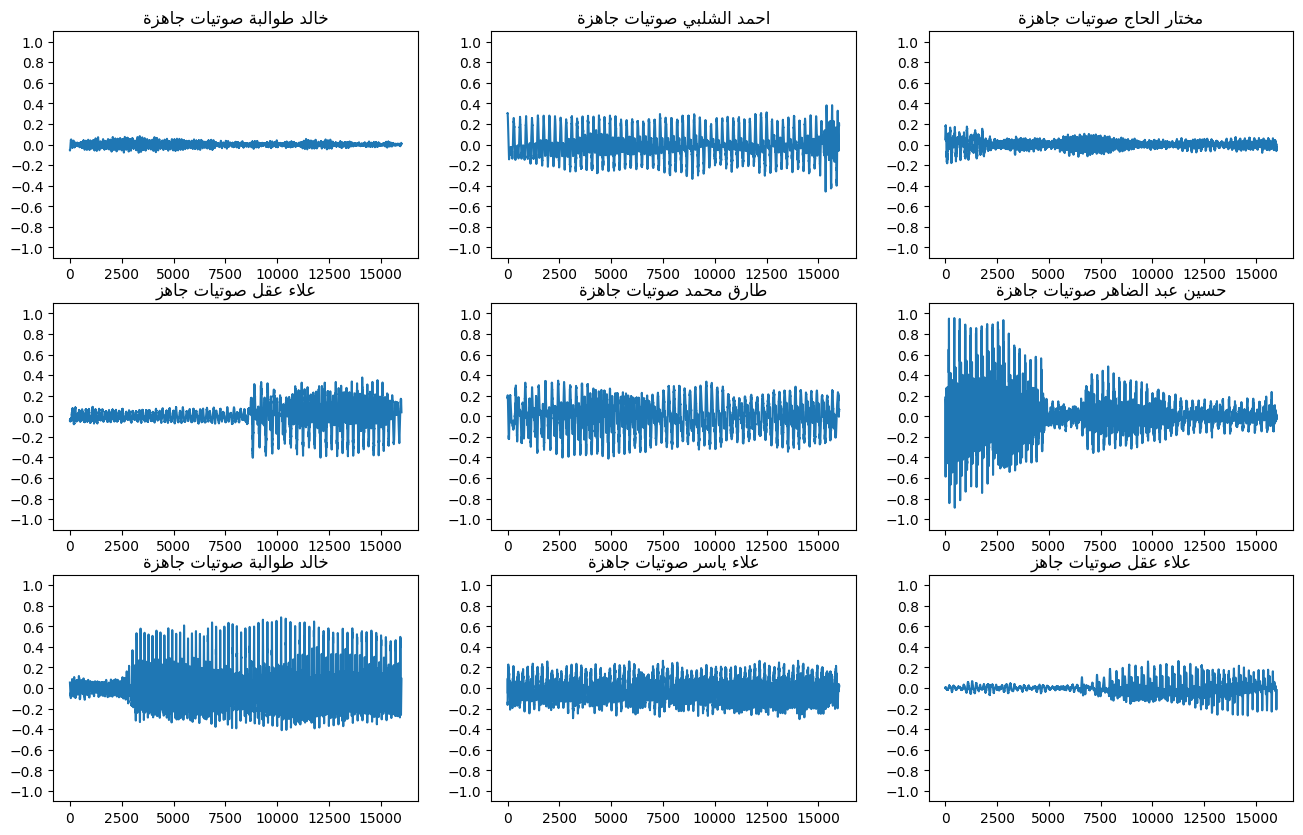

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(get_display(arabic_reshaper.reshape(label_names[example_labels[i]])))
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: خالد طوالبة صوتيات جاهزة
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: احمد الشلبي صوتيات جاهزة
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: مختار الحاج صوتيات جاهزة
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: علاء عقل صوتيات جاهز
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: طارق محمد صوتيات جاهزة
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [11]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

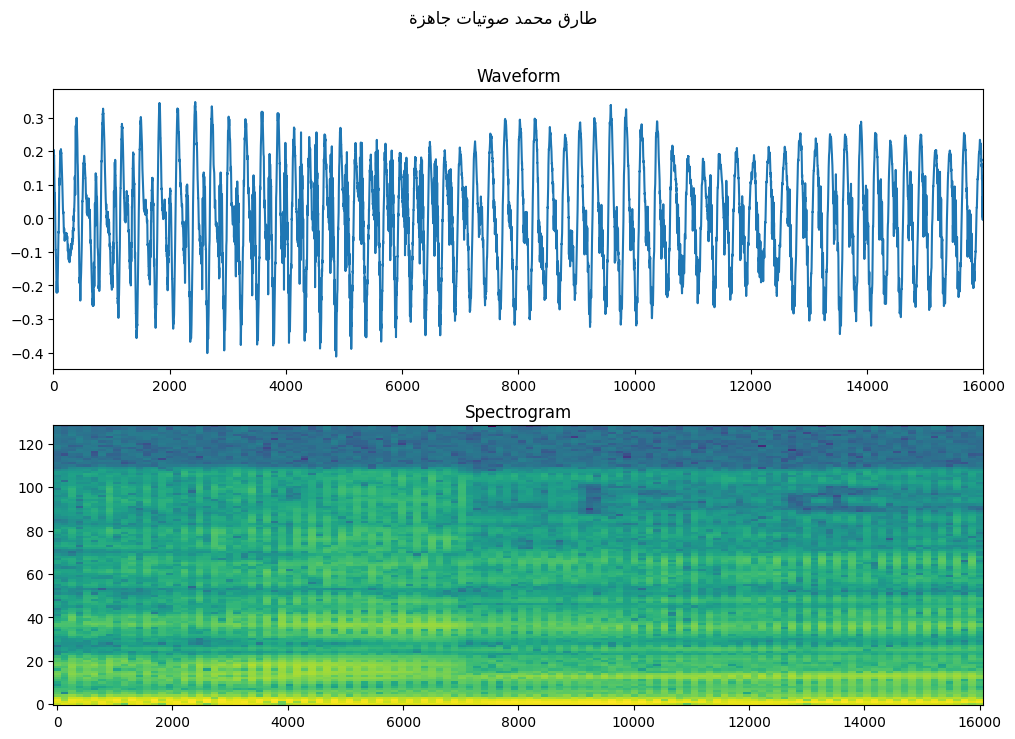

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(get_display(arabic_reshaper.reshape(label.title())))
plt.show()


Now, create spectrogram datasets from the audio datasets:

In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [15]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

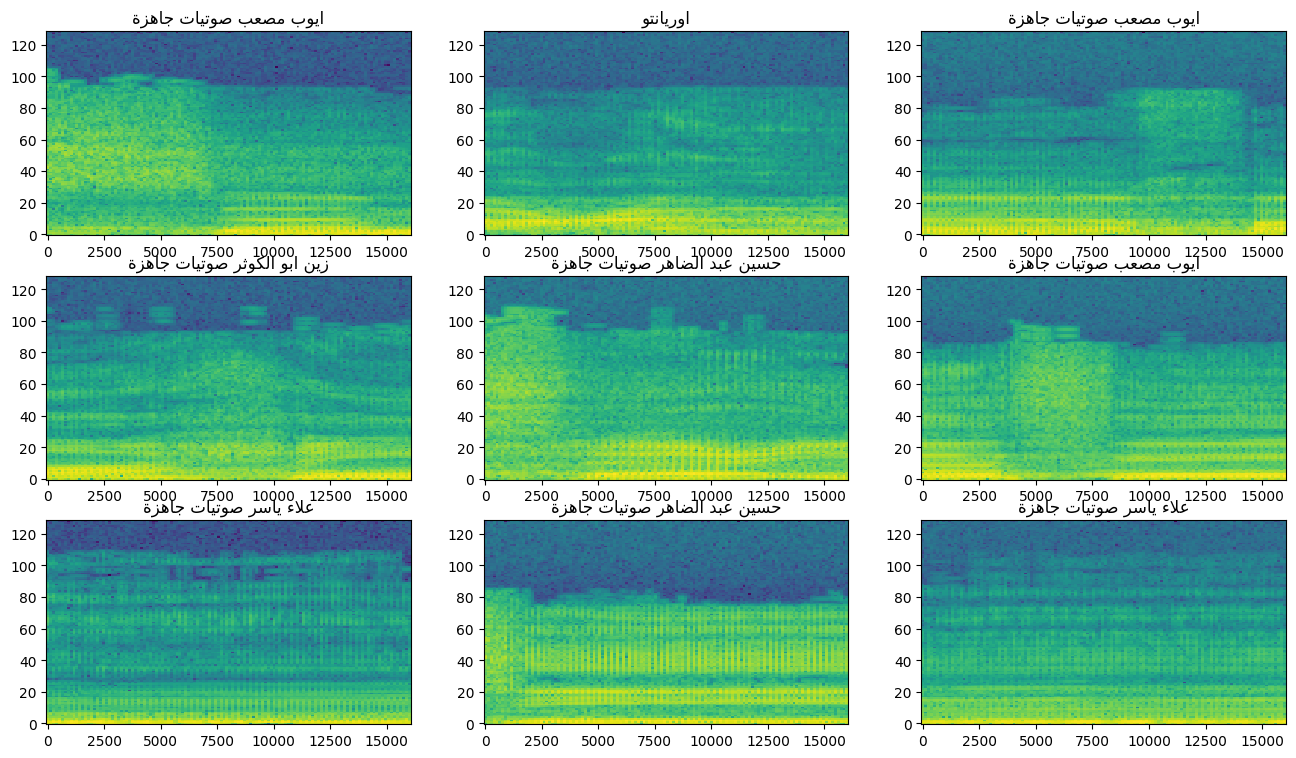

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(get_display(arabic_reshaper.reshape(label_names[example_spect_labels[i].numpy()])))

plt.show()

## Build and train the model

In [17]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [18]:


# Define the model-building function
def build_model(hp):
    input_shape = example_spectrograms.shape[1:]
    num_labels = len(label_names)

    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(64, 64),
        norm_layer,
        layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=8), 3, activation='relu'),
        layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=8), 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        
        layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=512, step=8), 3, activation='relu'),
        layers.Conv2D(hp.Int('conv4_units', min_value=64, max_value=512, step=8), 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        
        layers.Conv2D(hp.Int('conv5_units', min_value=128, max_value=1024, step=8), 3, activation='relu'),
        layers.Conv2D(hp.Int('conv6_units', min_value=128, max_value=1024, step=8), 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),
        
        layers.Flatten(),
        layers.Dense(hp.Int('dense1_units', min_value=128, max_value=1024, step=128), activation='relu'),
        layers.Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(hp.Int('dense2_units', min_value=128, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_5', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(num_labels),
    ])

    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Adjust as needed
    directory='QuranClf',  # Specify a directory for storing the tuner results
    project_name='QuranClassifier'
)

# Search for the best hyperparameters
# tuner.search(train_spectrogram_ds, epochs=10, validation_data=val_spectrogram_ds)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")


# model.summary()

Reloading Tuner from QuranClf/QuranClassifier/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fa0f41e8550>


Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [19]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'],
# )

Train the model over 10 epochs for demonstration purposes:

In [19]:
# EPOCHS = 90
# history = model.fit(
#     train_spectrogram_ds,
#     validation_data=val_spectrogram_ds,
#     epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),class_weight={0: 3.0872873036649215, 1: 0.6721822456540325, 10: 3.822832252836305, 11: 0.3563510348995316, 12: 0.686263456502764, 13: 0.6878645377661126, 14: 0.5917429754139488, 15: 19.333504098360656, 2: 9.002624045801527, 3: 0.6700816761363636, 4: 1.65987860661506, 5: 0.8258709733893558, 6: 0.6069705352547606, 7: 1.6471281424581006, 8: 1.459583849009901, 9: 8.968393536121672}
# )
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
model = build_model(best_hps)

# Train the final model on your entire training dataset
history=model.fit(train_spectrogram_ds, epochs=90, validation_data=val_spectrogram_ds,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/90


2024-02-24 14:30:48.620619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-24 14:30:49.047468: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-24 14:30:51.626736: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9ee02372f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 14:30:51.626769: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-24 14:30:51.639666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708777851.731758    1363 device_compiler.h:186] Compiled clust

41/41 [==============================] - 43s 486ms/step - loss: 2.4531 - accuracy: 0.1233 - val_loss: 2.3745 - val_accuracy: 0.1391
Epoch 2/90
41/41 [==============================] - 8s 188ms/step - loss: 2.0762 - accuracy: 0.2837 - val_loss: 1.7552 - val_accuracy: 0.4156
Epoch 3/90
41/41 [==============================] - 8s 188ms/step - loss: 1.5930 - accuracy: 0.4660 - val_loss: 1.3073 - val_accuracy: 0.5719
Epoch 4/90
41/41 [==============================] - 8s 189ms/step - loss: 1.1881 - accuracy: 0.6019 - val_loss: 1.0169 - val_accuracy: 0.6797
Epoch 5/90
41/41 [==============================] - 8s 188ms/step - loss: 0.9962 - accuracy: 0.6812 - val_loss: 0.8884 - val_accuracy: 0.7125
Epoch 6/90
41/41 [==============================] - 8s 188ms/step - loss: 0.8191 - accuracy: 0.7325 - val_loss: 0.7141 - val_accuracy: 0.7734
Epoch 7/90
41/41 [==============================] - 8s 188ms/step - loss: 0.6499 - accuracy: 0.7842 - val_loss: 0.5992 - val_accuracy: 0.8062
Epoch 8/90
41/41

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

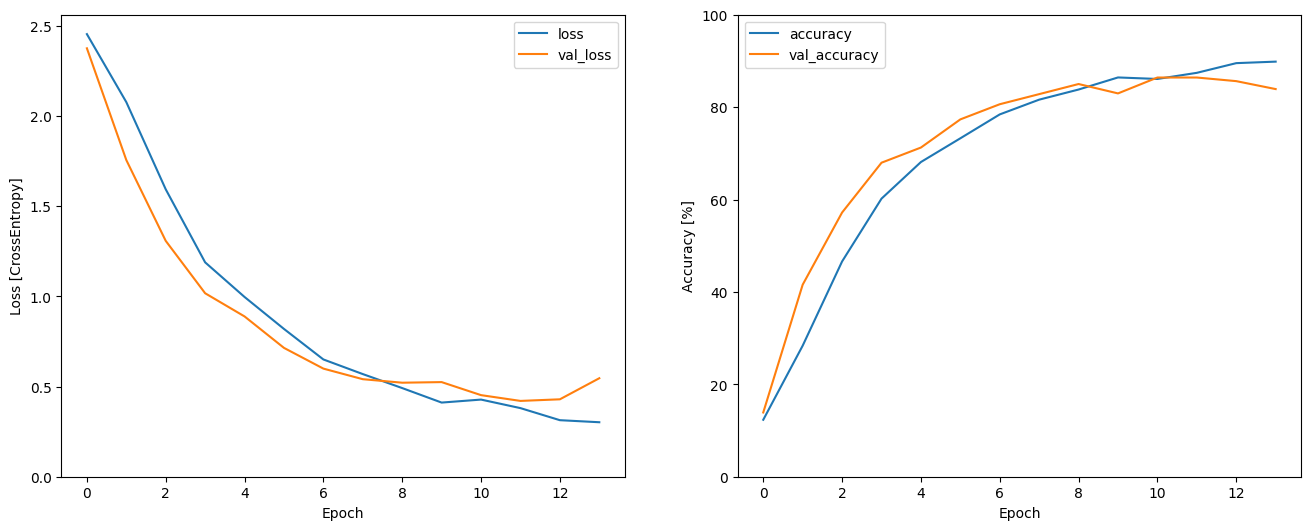

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [21]:
model.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 2s 337ms/step - loss: 0.5588 - accuracy: 0.8348


{'loss': 0.5588398575782776, 'accuracy': 0.8348484635353088}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [22]:
y_pred = model.predict(test_spectrogram_ds)

6/6 [==============================] - 0s 49ms/step


In [23]:
y_pred = tf.argmax(y_pred, axis=1)

In [24]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

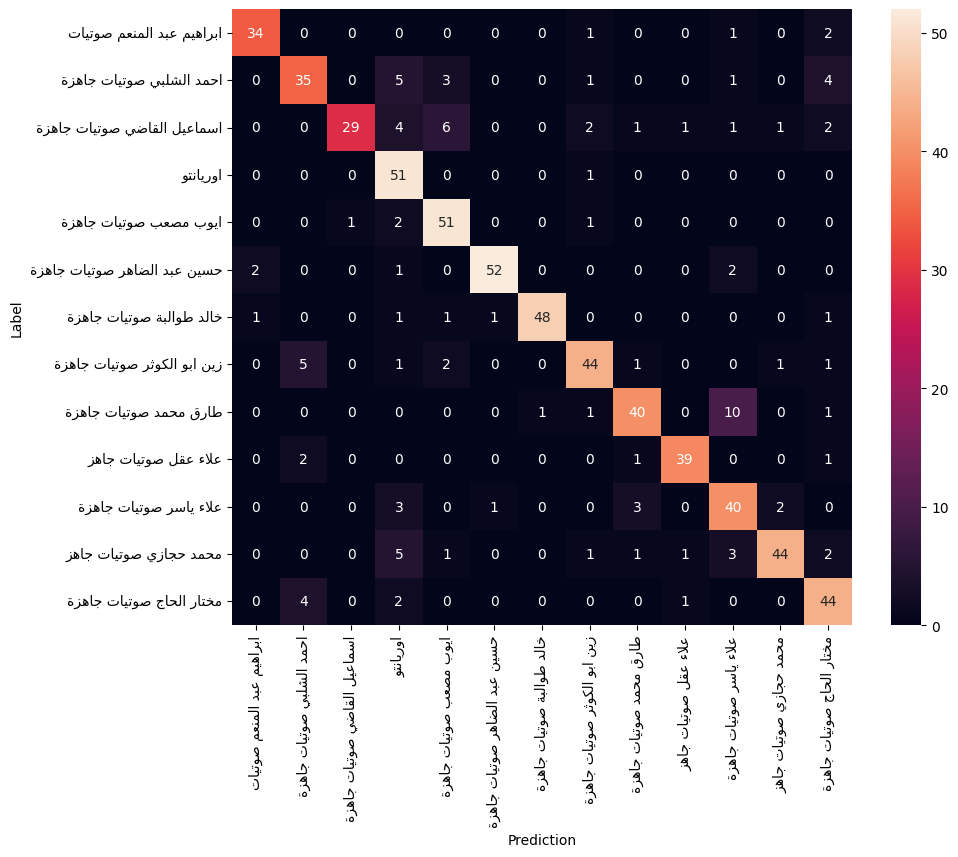

In [25]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Convert label names to strings with reshaping
reshaped_label_names = [get_display(arabic_reshaper.reshape(label)) for label in label_names]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=reshaped_label_names, yticklabels=reshaped_label_names, annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

In [33]:
x = "test_examples/AHMAD.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
print(x.shape)
x = tf.squeeze(x, axis=-1)
# waveform = get_random_segment(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = sorted(os.listdir("quran"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(x_labels[label])

display.display(display.Audio(waveform, rate=16000))

(16000, 1)
محمد حجازي صوتيات جاهز


In [28]:
tf.argmax(tf.nn.softmax(prediction[0]))

<tf.Tensor: shape=(), dtype=int64, numpy=5>

In [53]:
x = "test_examples/alaa_akl.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)

x = tf.squeeze(x, axis=-1)
waveform=x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# x_resized = tf.image.resize(x, (343, 129))
# x_resized = x_resized[..., tf.newaxis]
prediction = model(x)
label_names
x_labels = sorted(os.listdir("quran"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(label_names[label])

display.display(display.Audio(waveform, rate=16000))

علاء عقل صوتيات جاهز


In [ ]:
print(label_names)

## Export the model with preprocessing

In [26]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [27]:
export = ExportModel(model)
# export(tf.constant(str("output_folder/one_second_audio.mp3.wav")))

Save and reload the model, the reloaded model gives identical output:

In [28]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [ ]:

pred = imported("test_examples/alaa_akl.wav")
class_names=pred['class_names']
class_id=np.argmax(pred['class_ids'],-1)
final_pred=class_names[class_id]

In [ ]:
final_pred.numpy().decode('utf-8')

In [ ]:
pred['class_ids']